In [2]:
import tensorflow as tf
import numpy as np
import csv
from os import getcwd

In [59]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,6])], remainder='passthrough')

dataset = pd.read_csv('train.csv')

X = np.array(dataset.iloc[:700,[2,4,5,6,7,9,11]].values)
X_val = np.array(dataset.iloc[700:,[2,4,5,6,7,9,11]].values)
imputer.fit(X)
X = imputer.transform(X)
X_val = imputer.transform(X_val)

y = dataset.iloc[:700,1].values
y_val = dataset.iloc[700:,1].values

X = np.array(ct.fit_transform(X))
X_val = np.array(ct.transform(X_val))

X[:,[5,6,9]]= sc.fit_transform(X[:,[5,6,9]])
X_val[:,[5,6,9]]=sc.transform(X_val[:,[5,6,9]])

X = np.asarray(X).astype(np.float32)
X_val = np.asarray(X_val).astype(np.float32)

[[3 'male' 22.0 ... 0 7.25 'S']
 [1 'female' 38.0 ... 0 71.2833 'C']
 [3 'female' 26.0 ... 0 7.925 'S']
 ...
 [3 'female' 22.0 ... 0 7.7333 'Q']
 [1 'male' 49.0 ... 1 110.8833 'C']
 [3 'male' 42.0 ... 0 7.65 'S']]
[0.0 1.0 0.0 1.0 0.0 3 22.0 0 0 8.4583]
[[ 1.          0.          1.         ...  1.          0.
   4.0479774 ]
 [ 0.          1.          0.         ...  0.          0.
  -0.12296849]
 [ 1.          0.          1.         ...  0.          1.
  -0.3682312 ]
 ...
 [ 1.          0.          0.         ...  1.          2.
  -0.1817799 ]
 [ 0.          1.          1.         ...  0.          0.
  -0.04602142]
 [ 0.          1.          0.         ...  0.          0.
  -0.5071857 ]]


In [79]:
tf.keras.backend.clear_session()

initializer = tf.keras.initializers.GlorotNormal(seed=None)

from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32,activation='relu',input_shape=(10,),kernel_regularizer=regularizers.l2(0.01),kernel_initializer=initializer),
                                    tf.keras.layers.Dense(64,activation='relu'),
                                    tf.keras.layers.Dense(64,activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(128,activation='relu'),
                                    tf.keras.layers.Dense(256,activation='relu'),
                                    tf.keras.layers.Dense(512,activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01)),
                                    tf.keras.layers.Dense(1024,activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(2048,activation='relu'),
                                    tf.keras.layers.Dense(1024,activation='relu'),
                                    tf.keras.layers.Dense(512,activation='relu'),
                                    tf.keras.layers.Dense(256,activation='relu'),
                                    tf.keras.layers.Dense(1,activation='sigmoid')
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0034),metrics=['accuracy'])

In [86]:
history = model.fit(X,y,epochs=500,validation_data=(X_val,y_val))

Epoch 1/500
22/22 [==============================] - 2s 79ms/step - loss: 0.4542 - accuracy: 0.8300 - val_loss: 0.4301 - val_accuracy: 0.8639
Epoch 2/500
22/22 [==============================] - 2s 77ms/step - loss: 0.4509 - accuracy: 0.8229 - val_loss: 0.4317 - val_accuracy: 0.8377
Epoch 3/500
22/22 [==============================] - 2s 74ms/step - loss: 0.4587 - accuracy: 0.8329 - val_loss: 0.4549 - val_accuracy: 0.8272
Epoch 4/500
22/22 [==============================] - 2s 74ms/step - loss: 0.4540 - accuracy: 0.8171 - val_loss: 0.4528 - val_accuracy: 0.8429
Epoch 5/500
22/22 [==============================] - 2s 74ms/step - loss: 0.4319 - accuracy: 0.8329 - val_loss: 0.4098 - val_accuracy: 0.8429
Epoch 6/500
22/22 [==============================] - 2s 74ms/step - loss: 0.4071 - accuracy: 0.8314 - val_loss: 0.4229 - val_accuracy: 0.8534
Epoch 7/500
22/22 [==============================] - 2s 74ms/step - loss: 0.4525 - accuracy: 0.8357 - val_loss: 0.4200 - val_accuracy: 0.8377
Epoch 

(1e-06, 0.001, 0.0, 1.0)

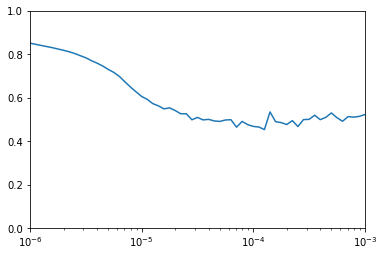

In [62]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 1])

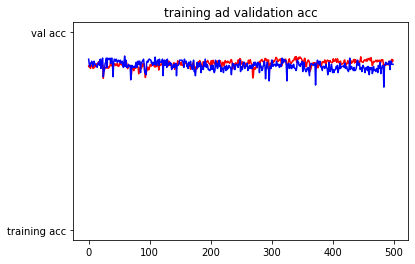

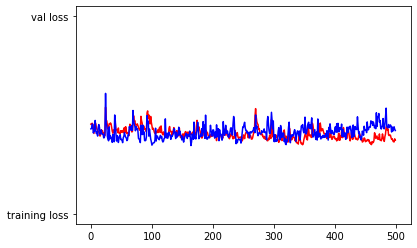

In [87]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs,acc,'r',"training acc")
plt.plot(epochs,val_acc,'b',"val acc")
plt.title('training ad validation acc')
plt.figure()

plt.plot(epochs,loss,'r',"training loss")
plt.plot(epochs,val_loss,'b',"val loss")

In [88]:
test_dataset = pd.read_csv('test.csv')
X_test = np.array(test_dataset.iloc[:,[1,3,4,5,6,8,10]].values)
imputer.fit(X_test)
X_test = imputer.transform(X_test)
X_test = np.array(ct.transform(X_test))
X_test[:,[5,6,9]]=sc.transform(X_test[:,[5,6,9]])
X_test = np.asarray(X_test).astype(np.float32)
print(X_test)

[[ 0.          1.          0.         ...  0.          0.
  -0.49706313]
 [ 1.          0.          0.         ...  1.          0.
  -0.51192594]
 [ 0.          1.          0.         ...  0.          0.
  -0.46375448]
 ...
 [ 0.          1.          0.         ...  0.          0.
  -0.50744486]
 [ 0.          1.          0.         ...  0.          0.
  -0.49310547]
 [ 0.          1.          1.         ...  1.          1.
  -0.23663968]]


In [89]:
preds = model.predict(X_test)

Survived = [0 if pred < 0.5 else 1 for pred in preds]
Survived[:5]
print(test_dataset.shape)
len(Survived)

(418, 11)


418

In [90]:
output = pd.DataFrame({'PassengerId':test_dataset.PassengerId,'Survived':Survived})
output.to_csv('my_submission.csv',index=False)

In [91]:
from google.colab import files
files.download("my_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>